<a href="https://colab.research.google.com/github/FREDY129053/Practise_Temp/blob/main/Practise_Veg_Fru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Подгрузка данных из датасета**

---



In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle  # Установка зависимости для скачки датасета

In [ ]:
from google.colab import files

files.upload()  # Загрузка файла с данными от Kaggle API

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fredy129053","key":"732172104435df3745774c6e74467316"}'}

In [ ]:
!mkdir ~/.kaggle  # Создание папки для данных Kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/  # Перенос файла в папку

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json  # Задаем права на файл

In [ ]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition  # Скачиваем датасет

100% 1.98G/1.98G [00:28<00:00, 97.9MB/s]
100% 1.98G/1.98G [00:28<00:00, 75.7MB/s]


In [ ]:
!unzip fruit-and-vegetable-image-recognition.zip  # Распаковываем датасет

In [ ]:
!mkdir /content/drive/MyDrive/Fruits_and_Vegetables_Datset

In [ ]:
!cp -r /content/test /content/drive/MyDrive/Fruits_and_Vegetables_Datset/test

In [ ]:
!cp -r /content/train /content/drive/MyDrive/Fruits_and_Vegetables_Datset/train

In [ ]:
!cp -r /content/validation /content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation

## Аугментация картинок

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Путь к папке с изображениями
folder_path = "/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train"

# Количество аугментаций на каждую картинку
num_augmentations = 3

# Параметры аугментации
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=[1, 2],
    horizontal_flip=True,
    brightness_range=[0.2, 1.5],
    fill_mode='nearest'
)

# Получаем список всех подпапок
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()][27:]

# Для каждой подпапки
for subfolder in subfolders:
    # Получаем список всех файлов изображений
    image_files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.png', '.jpg', '.jpeg'))]

    # Для каждого изображения
    for image_file in image_files:
        # Загружаем изображение и преобразуем его в массив
        img = load_img(image_file)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Генерируем и сохраняем аугментации
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=subfolder, save_prefix='MY_', save_format='jpeg'):
            i += 1
            if i >= num_augmentations:
                break

In [ ]:
import os

# Путь к папке с изображениями
folder_path = "путь_к_папке"

# Получаем список всех подпапок
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

# Для каждой подпапки
for subfolder in subfolders:
    # Получаем список всех файлов изображений с префиксом "MY_"
    my_image_files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.startswith('MY_')]

    # Удаляем файлы с префиксом "MY_"
    for my_image_file in my_image_files:
        os.remove(my_image_file)


## Тест модели MobileNet V3 Large

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

w, h = 224, 224

training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

base_model = MobileNetV3Large(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(36, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=preds)
model.summary()

Found 11961 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


12683000/12683000 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, None, None, 16)       432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, None, None, 16)       64        ['Conv[0][0]']                
 lization)                   

In [ ]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [ ]:
epochs = 8
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(training_set, validation_data=validation_set, epochs=epochs)

Epoch 1/8
374/374 [==============================] - 1793s 5s/step - loss: 1.5677 - accuracy: 0.5860 - val_loss: 0.3428 - val_accuracy: 0.8974
Epoch 2/8
374/374 [==============================] - 546s 1s/step - loss: 0.6126 - accuracy: 0.8103 - val_loss: 0.2462 - val_accuracy: 0.9259
Epoch 3/8
374/374 [==============================] - 534s 1s/step - loss: 0.4177 - accuracy: 0.8724 - val_loss: 0.2173 - val_accuracy: 0.9345
Epoch 4/8
374/374 [==============================] - 527s 1s/step - loss: 0.2907 - accuracy: 0.9124 - val_loss: 0.2025 - val_accuracy: 0.9544
Epoch 5/8
374/374 [==============================] - 526s 1s/step - loss: 0.2110 - accuracy: 0.9400 - val_loss: 0.1924 - val_accuracy: 0.9487
Epoch 6/8
374/374 [==============================] - 522s 1s/step - loss: 0.1509 - accuracy: 0.9582 - val_loss: 0.1671 - val_accuracy: 0.9516
Epoch 7/8
374/374 [==============================] - 524s 1s/step - loss: 0.1043 - accuracy: 0.9753 - val_loss: 0.1536 - val_accuracy: 0.9601
Epoch

In [ ]:
import json

model.save('/content/drive/MyDrive/model_MNv3LARGE.keras')
with open('/content/drive/MyDrive/train_history_MNv3LARGE', 'w') as f:
  json.dump(history.history, f)

## Создание тг бота

In [2]:
!pip install aiogram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 5.8 MB/s eta 0:00:00


In [3]:
%mkdir /content/temp

In [ ]:
import asyncio
import logging
import numpy as np
import tensorflow as tf

from aiogram import Bot, Dispatcher, types
from aiogram.filters.command import Command
from aiogram import F


bot = Bot(token='6882546934:AAFuE68_kEXz5Iw9lchWi-anbRrx-Tb5FkM')
dp = Dispatcher()
classes = [
    'Яблоко', 'Банан', 'Свекла', 'Болгарский перец',
    'Капуста', 'Стручковый перец', 'Морковь', 'Цветная капуста',
    'Перец чили', 'Кукуруза', 'Огурец', 'Баклажан',
    'Чеснок', 'Имбирь', 'Виноград', 'Халапеньо',
    'Киви', 'Лимон', 'Латук', 'Манго',
    'Лук', 'Апельсин', 'Паприка', 'Груша',
    'Горох', 'Ананас', 'Гранат', 'Картофель',
    'Редиска', 'Соевые бобы', 'Шпинат', 'Сладкая кукуруза',
    'Батат', 'Помидор', 'Репа', 'Арбуз'
]


@dp.message(Command('start'))
async def start_command(message: types.Message):
    await message.answer('Привет, чепушила')


@dp.message(F.photo)
async def get_photo_and_result(message: types.Message, bot: Bot):
    image_path = f'temp/{message.photo[1].file_id}.jpg'
    await bot.download(
        message.photo[-1],
        destination=image_path
    )

    await message.reply('Фото загружено!!!')
    await message.answer('Секунду...')
    result = get_prediction(image_path)
    await message.answer(result)



def get_prediction(image_path):
  model = tf.keras.models.load_model('/content/drive/MyDrive/model_MNv3LARGE.keras')
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  input_arr = np.array([input_arr])  # В двумерную матрицу

  prediction = model.predict(input_arr)
  result_index_of_prediction = np.where(prediction[0] == max(prediction[0]))

  answer = f"Я думаю на картинке {classes[result_index_of_prediction[0][0]]}"

  return answer


async def main():
    await dp.start_polling(bot)



await main()


1/1 [==============================] - 2s 2s/step


## Графики

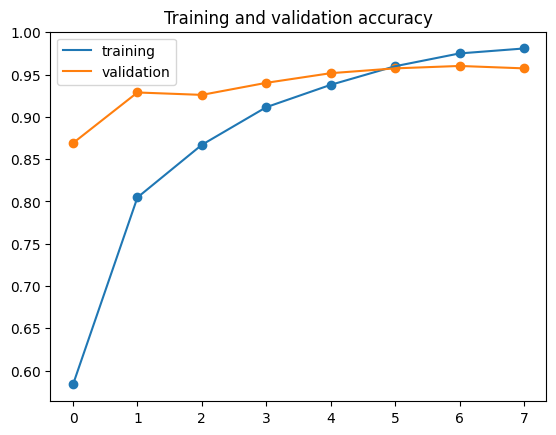

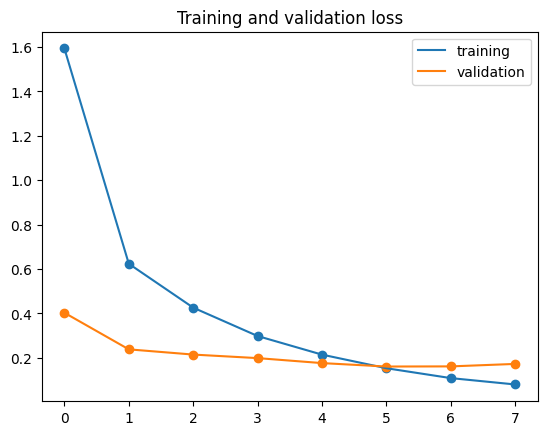

In [14]:
import json
import matplotlib.pyplot as plt
from pprint import pprint

with open('/content/drive/MyDrive/train_history_MNv3LARGE', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

accuracy, loss, val_accuracy, val_loss = train_data['accuracy'], train_data['loss'], train_data['val_accuracy'], train_data['val_loss']
epochs = range(len(accuracy))

# Plot training and validation accuracy per epoch
plt.plot(epochs, accuracy, label='training')
plt.scatter(epochs, accuracy)

plt.plot(epochs, val_accuracy, label='validation')
plt.scatter(epochs, val_accuracy)
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()

plt.plot(epochs, loss, label='training')
plt.scatter(epochs, loss)

plt.plot(epochs, val_loss, label='validation')
plt.scatter(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend()

plt.show()